## necesary imports

In [5]:
import numpy as np
import cv2 as cv
import copy
import matplotlib.pyplot as plt
from skimage import measure
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16

### necessary funcionts
The requirements are:
- **segment_background**.
    - *Function to segment the image by subtracting background and foreground with noise reduction.*
- **list_generator**.
    - *Function that generates list of moving objects.*
- **extract**.
    - *function that extracts the object of interest and their coords.*
- **preprocess_frames**.
    - *Preprocessing frames for VGG16.*
- **classify_objects**.
    - *batch clasification.*
- **draw_frame**.
    - *function that draws the reference and the text.*

In [6]:
def segment_background(img_1, img_2):
    img_1 = cv.GaussianBlur(img_1, (5, 5), 0)  # softens to reduce noise
    img_2 = cv.GaussianBlur(img_2, (5, 5), 0)
    img_adapted_1 = img_1.astype(np.int16)
    img_adapted_2 = img_2.astype(np.int16)
    img_rest = abs(img_adapted_2 - img_adapted_1)
    final_img = np.dot(img_rest[..., :3], [0.299, 0.587, 0.144])  # converst to grayscales
    _, result = cv.threshold(final_img, 20, 255, cv.THRESH_BINARY)
    return result  # bynari image

def list_generator(img_1, img_2, param):
    segment_li = segment_background(img_1, img_2)
    lbl_li = measure.label(segment_li)
    temp_li = measure.regionprops(lbl_li)
    final_li = []
    while True:
        x = np.array([len(region.coords) for region in temp_li])
        if len(x) == 0 or np.max(x) <= param:
            break
        i = np.argmax(x)
        final_li.append(temp_li[i])
        temp_li.pop(i)
    return final_li #final list

def extract(img_1, img_2, param):
    li = list_generator(img_1, img_2, param)
    result_li = []
    coords_li = []
    for region in li:
        min_x, min_y = np.min(region.coords, axis=0)
        max_x, max_y = np.max(region.coords, axis=0)
        coords_li.append([max_x, min_x, max_y, min_y]) # elements in coords_li  are the 4 points at the corners of the image
        new_img = img_2[min_x:max_x, min_y:max_y, :]
        result_li.append(new_img) # elements in result_li are a cutted img with the interest object
    return result_li, coords_li # list with interest objects and list with their coords 

def preprocess_frames(frames):
    frames_resized = [cv.resize(f, (224, 224)) for f in frames]
    frames_array = np.array([img_to_array(f) for f in frames_resized])
    return preprocess_input(frames_array)

def classify_objects(model, frames, batch_size=16):
    predictions = []
    for i in range(0, len(frames), batch_size):
        batch = frames[i:i + batch_size]
        batch_preprocessed = preprocess_frames(batch)
        preds = model.predict(batch_preprocessed)
        decoded = decode_predictions(preds, top=1)
        predictions.extend(decoded)
    return predictions

def draw_frame(img, coords_list, txt):
    img = copy.deepcopy(img)
    rectan = cv.rectangle(img, (coords_list[3], coords_list[1]), (coords_list[2], coords_list[0]), (255, 0, 0), 1)
    font = cv.FONT_HERSHEY_SIMPLEX
    frame = cv.putText(rectan, txt, (coords_list[3], coords_list[1]-10), font, 0.5, (255, 0, 0), 1, cv.LINE_AA)
    return frame # processed frame with text and marked reference

### And other functios just to show results are:
- **show_frame**.
    -*To show a sinlge frame.*
- **show_frames**.
    -*To show many frames.*

In [7]:
## functions to easy show results
def show_frame(frame):
    frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(frame_rgb)
    plt.axis('off')  
    plt.show()

def show_frames(frames, indices):
    for i in indices:
        print(f"Show frame {i}")
        show_frame(frames[i])

### Execution

In [8]:

# the model is loaded
model = VGG16()
# the video is captured    // mthe route of my project
vidcap = cv.VideoCapture(r'C:\Users\luisa\projects\12-VC\dog.MOV')

# read frames
frames = []
success, image = vidcap.read()
count = 0
while success:
    frames.append(image)
    success, image = vidcap.read()
    count += 1

# Process frames
background_frame = frames[0]  # choose the frame refrence
images = []
for x in range(count):
    img_frame = frames[x]
    img_cutted, coords_ref = extract(background_frame, img_frame, 1100)  # parameter set to 1100
    if img_cutted:
        preds = classify_objects(model, img_cutted)  # classify objects
        for t in range(len(coords_ref)):
            txt = f"{preds[t][0][1]} ({preds[t][0][2] * 100:.2f}%)"
            frames[x] = draw_frame(frames[x], coords_ref[t], txt)  # draw a refrence box and the best predictión
    images.append(frames[x])

# write the final video
x, y, z = images[0].shape
video = cv.VideoWriter("result.avi", cv.VideoWriter_fourcc(*'XVID'), 28, (y, x))
for image in images:
    video.write(image)

video.release()
print("Procces done")

1/1 [==============================] - 2s 2s/step
Procces done


#### Show some frames

Show frame 150


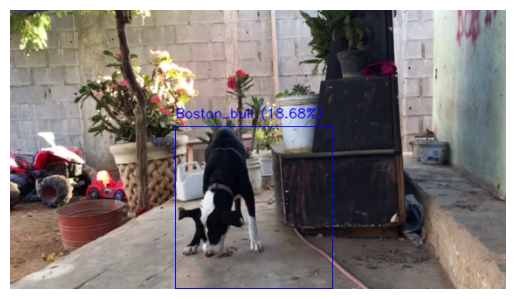

Show frame 175


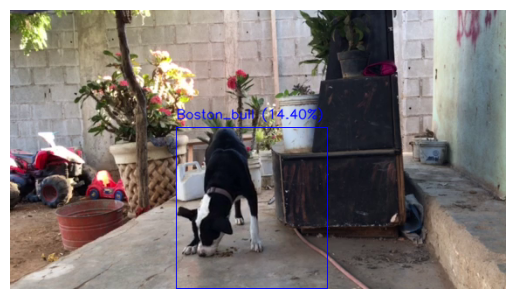

Show frame 200


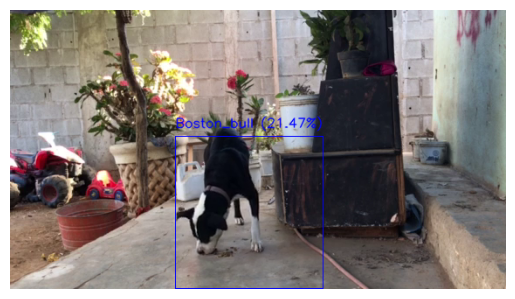

In [10]:
show_frames(images, [150, 175, 200])  